# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score
from sklearn.metrics import roc_curve, precision_score
from sklearn import set_config
from typing_extensions import Final
import joblib
import time


In [3]:
set_config(transform_output="pandas")

RandomStateNumber: Final[int] = 13

# Function

In [5]:
# function evaluate_model
def evaluate_model(model, X_test, y_test, title = None):
  summary = {}
  print(f"{title}\n")
  if hasattr(model, 'best_estimator_'):
    print("Best Model:", model.best_estimator_)
    print("Best Parameters:", model.best_params_)
    print(f"Best Score : {model.best_score_}\n")
  else:
    print("Model:", model)
    print("\nEvaluating the provided model on test data")
    # Use the provided model directly for predictions
    y_pred = model.predict(X_test)

  print("\nEvaluation on test data")
  baseline = 1 - y_test.mean()
  y_pred = model.predict(X_test)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print("ROC AUC: ", f"{auc:.4f}")
  print(f"Precision score: {precision:.4f}")
  print(f"Recall score: {recall:.4f}")
  print("Accuracy score: ", f"{accuracy:.4f}")
  print("Baseline Accuracy: ", f"{baseline:.4f}")

  summary["Model"] = title
  summary["Precision"] = precision
  summary["Recall"] = recall
  summary["F1"] = f1
  summary["ROC AUC"] = auc
  summary["Accuracy"] = accuracy
  summary["Baseline"] = baseline

  conf_matrix = confusion_matrix(y_test, y_pred)

  print(classification_report(y_test, y_pred))


  # Calculate ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  # Calculate AUC
  auc = roc_auc_score(y_test, y_pred)

  fig = plt.figure(figsize= (8,3), layout="constrained")
  ax1 = fig.add_subplot(1,2,1)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False,
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'],
              annot_kws={'size': 14}, ax= ax1)
  ax1.set_title("Confusion matrix", fontdict={"size":10})

  ax2 = fig.add_subplot(1,2,2)
  ax2.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
  ax2.plot([0, 1], [0, 1], 'k--') # plot the diagonal line
  ax2.set_xlabel('False Positive Rate')
  ax2.set_ylabel('True Positive Rate')
  ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontdict={"size":10})
  ax2.legend(loc="lower right")

  fig.suptitle(f"{title} Model", fontsize=12)

  plt.show()
  return summary


# Load Data

In [7]:
machine = pd.read_csv("factory_data.csv")
machine.shape

(20000, 9)

In [8]:
machine.columns.to_list()

['Unique ID',
 'Product ID',
 'Quality',
 'Ambient T (C)',
 'Process T (C)',
 'Rotation Speed (rpm)',
 'Torque (Nm)',
 'Tool Wear (min)',
 'Machine Status']

In [9]:
machine.drop(columns=["Unique ID", "Product ID"], axis= 1, inplace= True)

# Data cleaning and feature engineering

## Missing data

In [12]:
machine.isnull().sum().sort_values(ascending = False)

Rotation Speed (rpm)    1188
Quality                  991
Process T (C)            400
Ambient T (C)              0
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
dtype: int64

There is significant missing data in the Rotation Speed (rpm) and Quality.   
Replace missing Rotation Speed (rpm) using K-nearest neighbor.
Drop Process T (C) and Quality


In [14]:
machine.dropna(subset=["Process T (C)", "Quality"], inplace = True)
print("machine shape: ",machine.shape)


machine shape:  (18628, 7)


### Replace missing Rotation Speed data with K-nearest Neighbor Imputer

In [16]:
from sklearn.impute import KNNImputer

In [17]:
knn_imputer = KNNImputer(n_neighbors=5)
columns = ["Rotation Speed (rpm)", "Process T (C)", "Ambient T (C)", "Torque (Nm)", "Tool Wear (min)"]
machine_imputed = knn_imputer.fit_transform(machine[columns])

machine_cleaned = machine.copy()
machine_cleaned["Rotation Speed (rpm)"] = machine_imputed["Rotation Speed (rpm)"]
print("Missing Values")
print(machine_cleaned.isnull().sum())
print("\nmachine_cleaned shape:",machine_cleaned.shape)


Missing Values
Quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
Machine Status          0
dtype: int64

machine_cleaned shape: (18628, 7)


## Feature engineering

In [19]:
# Feature engineering: add Power (W) feature in the data
def add_power_feature(df):
    df = df.copy()
    df["Power (W)"] = df["Torque (Nm)"] * df["Rotation Speed (rpm)"] * 2 * np.pi / 60
    return df

# EDA

In [21]:
df = machine_cleaned.copy()
df = add_power_feature(df)
df.describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status,Power (W)
count,18628.000000,18628.000000,18628.000000,18628.000000,18628.000000,18628.000000,18628.000000
mean,26.902652,36.903242,1538.917919,39.982671,108.178119,0.033713,6279.962160
std,1.998556,1.483761,178.655605,9.970366,63.657999,0.180493,1067.808173
min,22.150000,32.550000,1168.000000,4.200000,0.000000,0.000000,1264.051220
25%,25.250000,35.750000,1423.300000,33.200000,53.000000,0.000000,5560.742043
50%,26.950000,36.950000,1503.000000,40.100000,108.000000,0.000000,6270.884925
75%,28.450000,37.950000,1612.000000,46.800000,163.000000,0.000000,7006.033314
max,31.350000,40.750000,2874.000000,76.600000,253.000000,1.000000,10469.923005


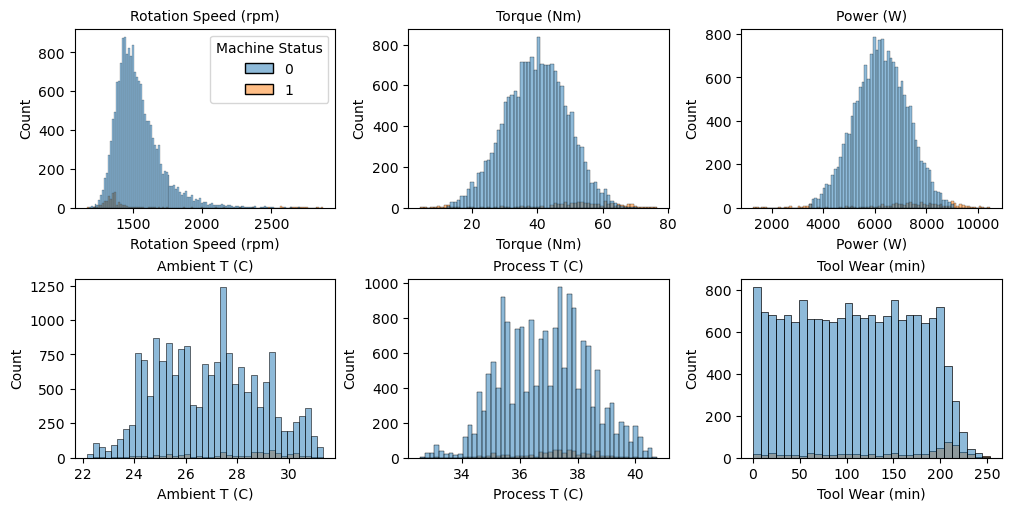

In [22]:
fig = plt.figure(figsize=(10,5), layout = "constrained")
ax1 = fig.add_subplot(2,3,1)
sns.histplot(df, x = "Rotation Speed (rpm)", hue = "Machine Status", ax= ax1)
ax1.set_title("Rotation Speed (rpm)", fontsize=10)
ax2 = fig.add_subplot(2,3,2)
sns.histplot(df, x = "Torque (Nm)", hue = "Machine Status", ax= ax2)
ax2.set_title("Torque (Nm)", fontsize=10)
ax2.get_legend().remove()
ax3 = fig.add_subplot(2,3,3)
sns.histplot(df, x = "Power (W)", hue = "Machine Status", ax= ax3)
ax3.set_title("Power (W)", fontsize=10)
ax3.get_legend().remove()

ax4 = fig.add_subplot(2,3,4)
sns.histplot(df, x = "Ambient T (C)", hue = "Machine Status", ax= ax4)
ax4.set_title("Ambient T (C)", fontsize=10)
ax4.get_legend().remove()
ax5 = fig.add_subplot(2,3,5)
sns.histplot(df, x = "Process T (C)", hue = "Machine Status", ax= ax5)
ax5.set_title("Process T (C)", fontsize=10)
ax5.get_legend().remove()
ax6 = fig.add_subplot(2,3,6)
sns.histplot(df, x = "Tool Wear (min)", hue = "Machine Status", ax= ax6)
ax6.set_title("Tool Wear (min)", fontsize=10)
ax6.get_legend().remove()

plt.show()

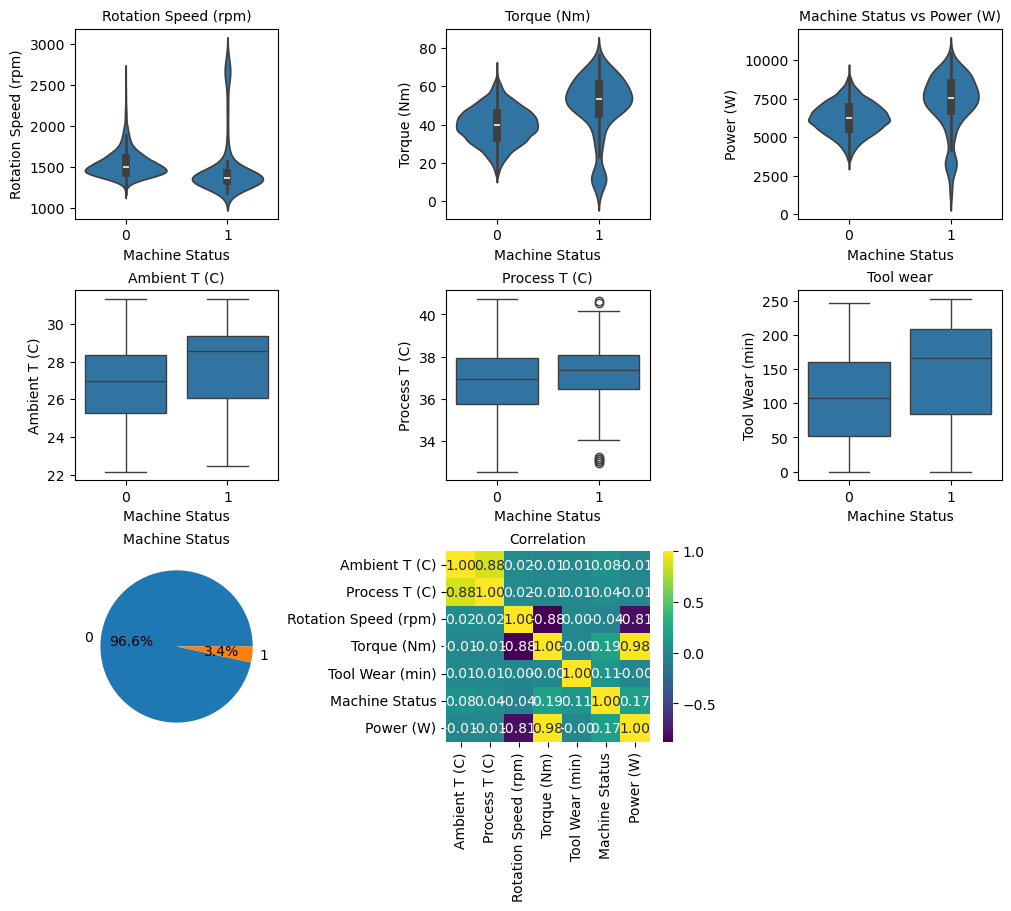

In [36]:
fig= plt.figure(figsize=(10,9), layout = "constrained")

ax1 = fig.add_subplot(3,3,1)
sns.violinplot(df, x = "Machine Status", y = "Rotation Speed (rpm)",
                ax= ax1)
ax1.set_title("Rotation Speed (rpm)", fontsize=10)

ax2 = fig.add_subplot(3,3,2)
sns.violinplot(df, x = "Machine Status", y = "Torque (Nm)",
                ax= ax2)
ax2.set_title("Torque (Nm)", fontsize=10)

ax3 = fig.add_subplot(3,3,3)
sns.violinplot(df, x = "Machine Status", y = "Power (W)",
            ax= ax3)
ax3.set_title("Machine Status vs Power (W)", fontsize=10)

ax4 = fig.add_subplot(3,3,4)
sns.boxplot(df, x = "Machine Status", y = "Ambient T (C)",
           ax= ax4)
ax4.set_title("Ambient T (C)", fontsize=10)

ax5 = fig.add_subplot(3,3,5)
sns.boxplot(df, x = "Machine Status", y = "Process T (C)",
           ax= ax5)
ax5.set_title("Process T (C)", fontsize=10)

ax6 = fig.add_subplot(3,3,6)
sns.boxplot(df, x = "Machine Status", y = "Tool Wear (min)",
           ax= ax6)
ax6.set_title("Tool wear", fontsize=10)

ax7 = fig.add_subplot(3,3,7)
ax7.pie(x = df["Machine Status"].value_counts(),
             labels = df["Machine Status"].value_counts().index,
            autopct = "%1.1f%%")
ax7.set_title("Machine Status", fontsize=10)

ax8 = fig.add_subplot(3,3,8)
sns.heatmap(df.corr(numeric_only = True), annot = True, fmt= ".2f", cmap = "viridis", ax= ax8)
ax8.set_title("Correlation", fontsize=10)

plt.show()


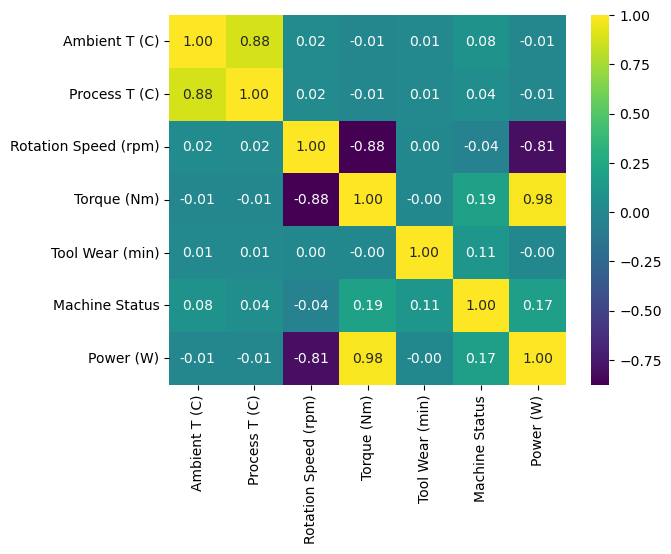

In [38]:
sns.heatmap(df.corr(numeric_only = True), annot = True, fmt= ".2f", cmap = "viridis");

# Machine Learning

## Data preparation and Balance Machine Status class


Machine Status
0    18000
1      628
Name: count, dtype: int64


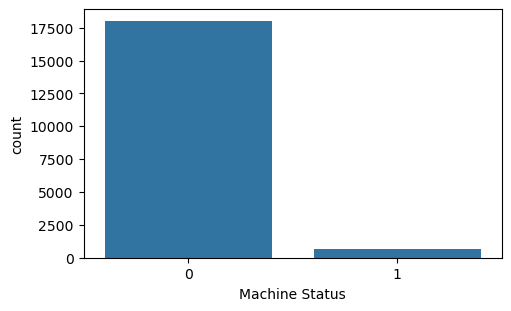

In [149]:
# Imbalance data
print(machine_cleaned["Machine Status"].value_counts())

fig = plt.figure(figsize=(5,3), layout = "constrained")
sns.countplot(machine_cleaned, x = "Machine Status")
plt.show()

### Split Train and Test Data

In [151]:
# Split in train and test data
X = machine_cleaned.drop(columns = ["Machine Status"], axis = 1)
y = machine_cleaned["Machine Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= RandomStateNumber, stratify= y)

### Unbalance Data

In [153]:
# oversampling to increase the X_train, y_train machine status "1" to the same count as "0"
Xy_train = pd.concat([X_train, y_train], axis = 1)

# Filter rows where Machine Status is 1
status_1 = Xy_train[Xy_train['Machine Status'] == 1].copy()

targetQty = Xy_train["Machine Status"].value_counts().max()
num_samples = targetQty - len(status_1)

# Perform bootstrapping with replacement
oversampling_status_1 = status_1.sample(n=num_samples, replace=True, random_state= RandomStateNumber)

# concat into train dataset
train = pd.concat([Xy_train, oversampling_status_1], axis = 0, ignore_index= True)
train["Machine Status"].value_counts()
# replace X_train, y_train with bootstrapped data
X_train = train.drop(columns = ["Machine Status"], axis = 1)
y_train = train["Machine Status"]
X_train.head()

,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
0,L,26.15,37.65,1483.0,43.5,15
1,H,27.15,38.45,1339.0,53.4,123
2,L,25.85,35.55,1426.0,38.6,16
3,L,28.85,36.65,1456.0,58.1,145
4,L,28.35,37.45,1522.0,41.0,114


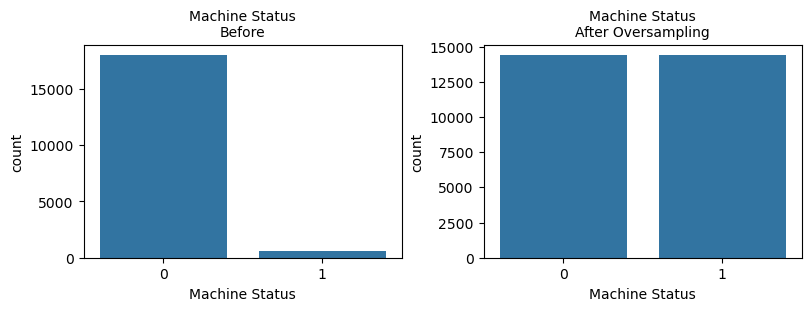

In [154]:
# print(machine_cleaned["Machine Status"].value_counts())

fig = plt.figure(figsize=(8,3), layout = "constrained")
ax1 = fig.add_subplot(1,2,1)
sns.countplot(machine_cleaned, x = "Machine Status", ax= ax1)
ax1.set_title("Machine Status\nBefore", fontsize=10)

ax2 = fig.add_subplot(1,2,2)
sns.countplot(train, x = "Machine Status", ax= ax2)
ax2.set_title("Machine Status\nAfter Oversampling", fontsize=10)
plt.show()

## Feature engineering & Data encording

### Pipeline

In [157]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

power_transformer = FunctionTransformer(add_power_feature)

numeric_features = [
    'Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)',
    'Power (W)', 'Torque (Nm)', 'Tool Wear (min)'
]
categorical_features = ['Quality']

# Column Transformer for the different transformation
transformColumns = ColumnTransformer(
    transformers =[
        ('num', StandardScaler(), numeric_features),
         ('cat', OneHotEncoder(sparse_output= False), categorical_features)
         ],
    verbose_feature_names_out= False)

preprocessing = Pipeline([
    ('add_power', power_transformer),
     ('transformColumns', transformColumns)
     ])

# Create pipeline
pipe = Pipeline([
    ('classifier', LogisticRegression(random_state= RandomStateNumber))  # Placeholder model
])

### Preprocess data X_train_scaled, X_test_scaled

In [159]:
# preprocess train & test data
X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled = preprocessing.transform(X_test)

In [160]:
X_train_scaled.head()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Power (W),Torque (Nm),Tool Wear (min),Quality_H,Quality_L,Quality_M
0,-0.582301,0.417417,-0.116365,-0.000958,-0.094386,-1.562698,0.0,1.0,0.0
1,-0.102535,0.980098,-0.609527,0.469861,0.602001,-0.026406,1.0,0.0,0.0
2,-0.726231,-1.059620,-0.311575,-0.638419,-0.439062,-1.548473,0.0,1.0,0.0
3,0.713067,-0.285934,-0.208833,1.351353,0.932609,0.286542,0.0,1.0,0.0
4,0.473184,0.276747,0.017199,-0.142935,-0.270241,-0.154430,0.0,1.0,0.0


## Model

### Initalise

In [163]:
# Stratified KFold for cross valuation score

stratified_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state= RandomStateNumber)
summaries = []
scoring_metrics: Final = "recall"

### Logistic Regression

In [165]:
time.time()

1748680039.521249

In [166]:
# Logistic Regression
time_start = time.time()
param_grid_lr = [
    {
        'classifier': [LogisticRegression(random_state= RandomStateNumber)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'saga']
    }]

grid_lr = GridSearchCV(pipe, param_grid_lr, cv=stratified_cv, scoring= scoring_metrics, n_jobs = -1)

grid_lr.fit(X_train_scaled, y_train)
time_lapse = time.time() - time_start
time_lapse

1.8654561042785645

Logistic Regression

Best Model: Pipeline(steps=[('classifier',
                 LogisticRegression(C=0.1, random_state=13,
                                    solver='liblinear'))])
Best Parameters: {'classifier': LogisticRegression(random_state=13), 'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Score : 0.8393055555555555


Evaluation on test data
ROC AUC:  0.8458
Precision score: 0.1707
Recall score: 0.8333
Accuracy score:  0.8575
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3600
           1       0.17      0.83      0.28       126

    accuracy                           0.86      3726
   macro avg       0.58      0.85      0.60      3726
weighted avg       0.97      0.86      0.90      3726



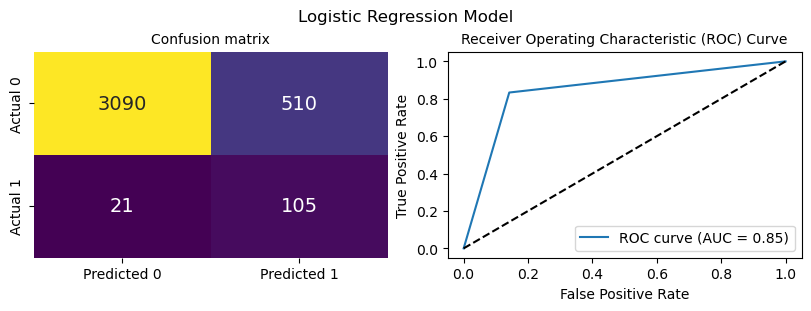

In [167]:
summaries.append(evaluate_model(grid_lr, X_test_scaled, y_test, "Logistic Regression"))

### Random Forest Classifier

In [169]:
# Random Forest Classifier
time_start = time.time()
param_grid_for = [
    {
        'classifier': [RandomForestClassifier(random_state= RandomStateNumber)],
        'classifier__n_estimators': [100, 200, 400],
        'classifier__max_depth': [5, 8, 10, 12, 15, 20, 50, 100, None]
    }]

grid_for = GridSearchCV(pipe, param_grid = param_grid_for, 
                             cv=stratified_cv, scoring= scoring_metrics, 
                             n_jobs = -1)

grid_for.fit(X_train_scaled, y_train)
time_lapse = time.time() - time_start
time_lapse

79.25525403022766

Random Forest Classifier

Best Model: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=13))])
Best Parameters: {'classifier': RandomForestClassifier(random_state=13), 'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best Score : 1.0


Evaluation on test data
ROC AUC:  0.9429
Precision score: 0.6264
Recall score: 0.9048
Accuracy score:  0.9785
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3600
           1       0.63      0.90      0.74       126

    accuracy                           0.98      3726
   macro avg       0.81      0.94      0.86      3726
weighted avg       0.98      0.98      0.98      3726



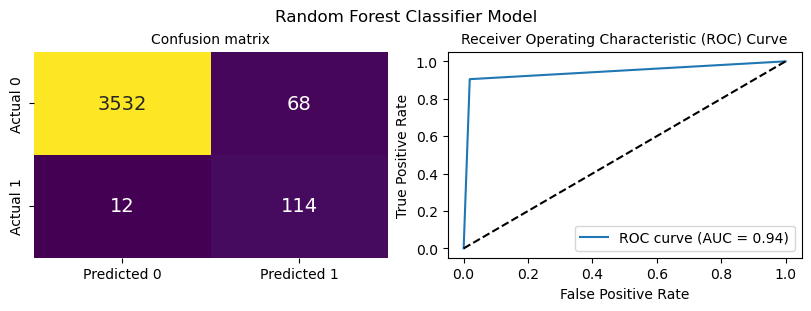

In [170]:
summaries.append(evaluate_model(grid_for, X_test_scaled, y_test, "Random Forest Classifier"))

Feature Importances: [0.08216961 0.04263642 0.24808309 0.19364679 0.21590618 0.20600858
 0.00162178 0.00560745 0.00432008]
Rotation Speed (rpm)    0.248083
Torque (Nm)             0.215906
Tool Wear (min)         0.206009
Power (W)               0.193647
Ambient T (C)           0.082170
Process T (C)           0.042636
Quality_L               0.005607
Quality_M               0.004320
Quality_H               0.001622
dtype: float64


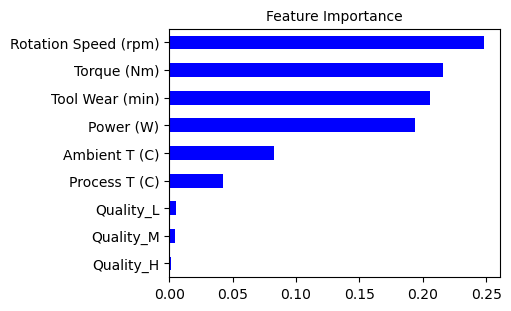

In [171]:
# Access the classifier step within the pipeline
best_model = grid_for.best_estimator_
classifier_model = best_model.named_steps['classifier']

# Check if the classifier has the feature_importances_ attribute
if hasattr(classifier_model, 'feature_importances_'):
    # Access and print the feature importances
    important = classifier_model.feature_importances_
    print("Feature Importances:", important)

else:
    print("The best model does not have the attribute 'feature_importances_'.")
columns = X_train_scaled.columns
coeff = pd.Series(important, columns)
print(coeff.sort_values(ascending = False))

fig = plt.figure(figsize=(5,3), layout = "constrained")

coeff.sort_values(ascending = True).plot.barh(color="blue")
plt.title("Feature Importance", fontsize=10)
plt.show()


### KNeighbor Classifier

In [173]:
# K Neighbor Classifier
time_start = time.time()
param_grid_knn = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': range(3, 30),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }]

grid_knn = GridSearchCV(pipe, param_grid_knn, cv=stratified_cv, scoring= scoring_metrics, n_jobs = -1)

grid_knn.fit(X_train_scaled, y_train)
time_lapse = time.time() - time_start
time_lapse

9.370648860931396

K Neighbor Classifier

Best Model: Pipeline(steps=[('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])
Best Parameters: {'classifier': KNeighborsClassifier(), 'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}
Best Score : 1.0


Evaluation on test data
ROC AUC:  0.9208
Precision score: 0.6585
Recall score: 0.8571
Accuracy score:  0.9801
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3600
           1       0.66      0.86      0.74       126

    accuracy                           0.98      3726
   macro avg       0.83      0.92      0.87      3726
weighted avg       0.98      0.98      0.98      3726



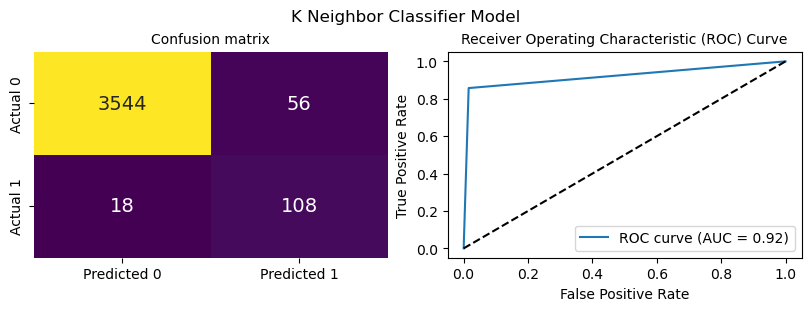

In [174]:
summaries.append(evaluate_model(grid_knn, X_test_scaled, y_test, "K Neighbor Classifier"))

### Gradient Boosting Classifier

In [176]:
# Gradient Boosting Classifier
time_start = time.time()
param_grid_gb = [
    {
        'classifier': [GradientBoostingClassifier(random_state= RandomStateNumber)],
        'classifier__validation_fraction' : [0.1, 0.15, 0.2],
        'classifier__n_iter_no_change': [8, 9,10],
        'classifier__loss':['log_loss', 'exponential'],
        'classifier__learning_rate': np.arange(0.001, 0.2, 0.01),
        'classifier__max_depth': range(3, 10),
        'classifier__n_estimators': [100, 200, 400, 500],
        'classifier__max_features':["sqrt", "log2", None]
    }]


grid_gb = RandomizedSearchCV(pipe, param_distributions = param_grid_gb, 
                             cv=stratified_cv, scoring= scoring_metrics, 
                             n_jobs = -1, random_state = RandomStateNumber)

grid_gb.fit(X_train_scaled, y_train)

time.time() - time_start


26.609079122543335

Gradient Boosting Classifier

Best Model: Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(learning_rate=0.15099999999999997,
                                            loss='exponential', max_depth=8,
                                            n_estimators=500,
                                            n_iter_no_change=9, random_state=13,
                                            validation_fraction=0.2))])
Best Parameters: {'classifier__validation_fraction': 0.2, 'classifier__n_iter_no_change': 9, 'classifier__n_estimators': 500, 'classifier__max_features': None, 'classifier__max_depth': 8, 'classifier__loss': 'exponential', 'classifier__learning_rate': 0.15099999999999997, 'classifier': GradientBoostingClassifier(random_state=13)}
Best Score : 1.0


Evaluation on test data
ROC AUC:  0.9502
Precision score: 0.8769
Recall score: 0.9048
Accuracy score:  0.9925
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0 

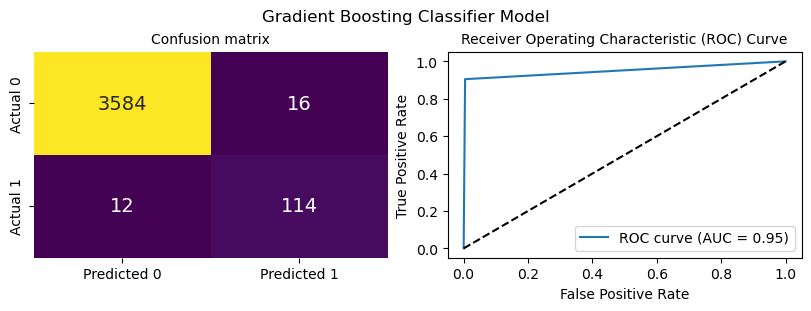

In [177]:
summaries.append(evaluate_model(grid_gb, X_test_scaled, y_test, "Gradient Boosting Classifier"))

In [181]:
summaries_df = pd.DataFrame(summaries)
summaries_df.sort_values(by= "Recall", ascending= False)

,Model,Precision,Recall,F1,ROC AUC,Accuracy,Baseline
1,Random Forest Classifier,0.626374,0.904762,0.740260,0.942937,0.978529,0.966184
3,Gradient Boosting Classifier,0.876923,0.904762,0.890625,0.950159,0.992485,0.966184
2,K Neighbor Classifier,0.658537,0.857143,0.744828,0.920794,0.980140,0.966184
0,Logistic Regression,0.170732,0.833333,0.283401,0.845833,0.857488,0.966184


### Reduced feature 1

In [218]:
# Test reduce feature
remove_feature = ["Quality_L", "Quality_M", "Quality_H"]
X_train_reduced1 = X_train_scaled.drop(columns = remove_feature, axis = 1)
X_test_reduced1 = X_test_scaled.drop(columns = remove_feature, axis = 1)

In [220]:
X_test_reduced1.columns

Index(['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Power (W)',
       'Torque (Nm)', 'Tool Wear (min)'],
      dtype='object')

In [222]:
grid_for_reduced1 = GridSearchCV(pipe, param_grid = param_grid_for, 
                             cv=stratified_cv, scoring= scoring_metrics, 
                             n_jobs = -1)
grid_for_reduced1.fit(X_train_reduced1, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(random_state=13))]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestClassifier(random_state=13)],
                          'classifier__max_depth': [5, 8, 10, 12, 15, 20, 50,
                                                    100, None],
                          'classifier__n_estimators': [100, 200, 400]}],
             scoring='recall')

Random Forest Classifier (reduced1)

Best Model: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, random_state=13))])
Best Parameters: {'classifier': RandomForestClassifier(random_state=13), 'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best Score : 1.0


Evaluation on test data
ROC AUC:  0.9409
Precision score: 0.5787
Recall score: 0.9048
Accuracy score:  0.9745
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3600
           1       0.58      0.90      0.71       126

    accuracy                           0.97      3726
   macro avg       0.79      0.94      0.85      3726
weighted avg       0.98      0.97      0.98      3726



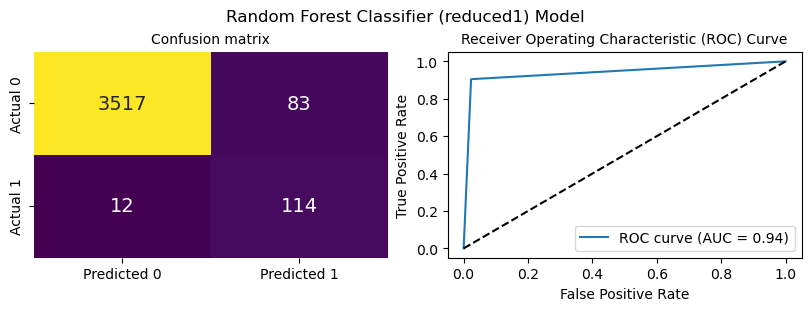

In [230]:
summaries.append(evaluate_model(grid_for_reduced1, X_test_reduced1, y_test, "Random Forest Classifier (reduced1)"))

### Reduced feature 2

In [233]:
remove_feature = ["Quality_L", "Quality_M", "Quality_H", "Ambient T (C)", "Process T (C)", "Power (W)"]
X_train_reduced2 = X_train_scaled.drop(columns = remove_feature, axis = 1)
X_test_reduced2 = X_test_scaled.drop(columns = remove_feature, axis = 1)
X_train_reduced2.columns

Index(['Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)'], dtype='object')

In [235]:
grid_for_reduced2 = GridSearchCV(pipe, param_grid = param_grid_for, 
                             cv=stratified_cv, scoring= scoring_metrics, 
                             n_jobs = -1)
grid_for_reduced2.fit(X_train_reduced2, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=13, shuffle=True),
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(random_state=13))]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestClassifier(random_state=13)],
                          'classifier__max_depth': [5, 8, 10, 12, 15, 20, 50,
                                                    100, None],
                          'classifier__n_estimators': [100, 200, 400]}],
             scoring='recall')

Random Forest Classifier (reduced2)

Best Model: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=12, random_state=13))])
Best Parameters: {'classifier': RandomForestClassifier(random_state=13), 'classifier__max_depth': 12, 'classifier__n_estimators': 100}
Best Score : 1.0


Evaluation on test data
ROC AUC:  0.8960
Precision score: 0.3419
Recall score: 0.8492
Accuracy score:  0.9396
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3600
           1       0.34      0.85      0.49       126

    accuracy                           0.94      3726
   macro avg       0.67      0.90      0.73      3726
weighted avg       0.97      0.94      0.95      3726



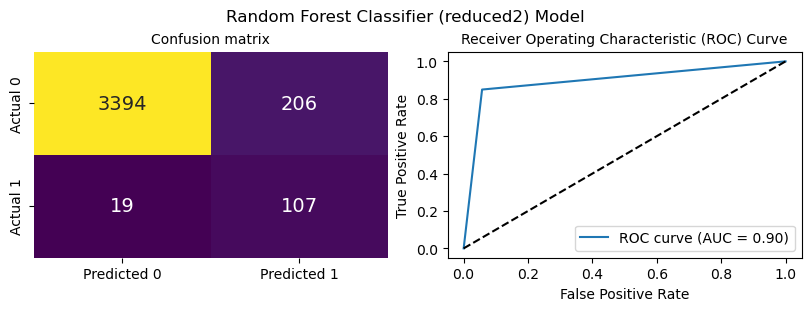

In [240]:
summaries.append(evaluate_model(grid_for_reduced2, X_test_reduced2, y_test, "Random Forest Classifier (reduced2)"))

In [242]:
result_df= pd.DataFrame(summaries).sort_values(by= "Recall", ascending= False)
result_df.drop_duplicates(inplace=True)
result_df.sort_values(by="Recall", ascending =False)

,Model,Precision,Recall,F1,ROC AUC,Accuracy,Baseline
1,Random Forest Classifier,0.626374,0.904762,0.740260,0.942937,0.978529,0.966184
3,Gradient Boosting Classifier,0.876923,0.904762,0.890625,0.950159,0.992485,0.966184
4,Random Forest Classifier (reduced1),0.578680,0.904762,0.705882,0.940853,0.974503,0.966184
2,K Neighbor Classifier,0.658537,0.857143,0.744828,0.920794,0.980140,0.966184
5,Random Forest Classifier (reduced2),0.341853,0.849206,0.487472,0.895992,0.939614,0.966184
0,Logistic Regression,0.170732,0.833333,0.283401,0.845833,0.857488,0.966184


### Save Best Model

In [244]:
best_model = grid_for.best_estimator_

filename = "best_model.pkl"
joblib.dump(best_model, filename)


['best_model.pkl']

# Model Evaluation

In [246]:
import joblib
# load the best model
model = joblib.load('best_model.pkl')

In [254]:
X_test_scaled = preprocessing.transform(X_test)
X_test_scaled.head()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Power (W),Torque (Nm),Tool Wear (min),Quality_H,Quality_L,Quality_M
5708,0.856997,1.050433,0.322001,-0.157574,-0.439062,0.258092,0.0,1.0,0.0
5283,1.576646,2.105459,0.027474,-0.042235,-0.206933,0.286542,0.0,1.0,0.0
2511,-0.726231,-0.918950,0.030898,-0.121617,-0.263207,-1.491573,0.0,0.0,1.0
1472,-0.966114,-0.426604,-0.270478,-0.035939,-0.024044,-0.012181,0.0,0.0,1.0
7457,-0.198488,0.980098,0.044597,-0.574154,-0.579746,-0.723427,0.0,1.0,0.0


Best Model: Random Forest Classifier

Model: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=200,
                                        random_state=13))])

Evaluating the provided model on test data

Evaluation on test data
ROC AUC:  0.9429
Precision score: 0.6264
Recall score: 0.9048
Accuracy score:  0.9785
Baseline Accuracy:  0.9662
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3600
           1       0.63      0.90      0.74       126

    accuracy                           0.98      3726
   macro avg       0.81      0.94      0.86      3726
weighted avg       0.98      0.98      0.98      3726



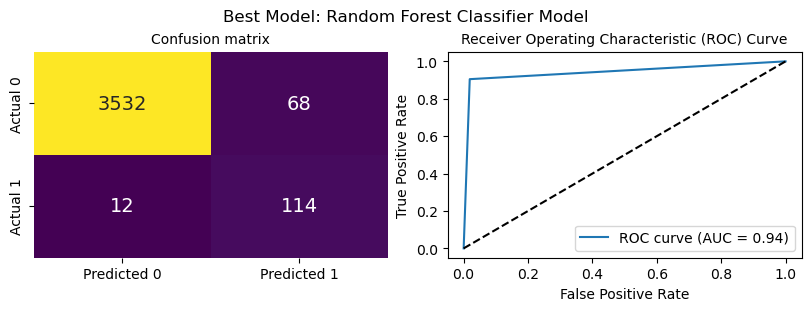

In [250]:
res = evaluate_model(model, X_test_scaled, y_test, "Best Model: Random Forest Classifier")